# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

План выполнения проекта: 

* загрузить и подготовить данные;
* обучить разные модели (для каждой модели попробовать различные гиперпараметры);
* проанализировать скорость работы и качество моделей и выбрать лучшую из них.

## Подготовка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import time
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
# приведем столбцы со временем к надлежащему формату
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format = '%Y-%m-%d')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format = '%Y-%m-%d')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format = '%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [4]:
# проведем проверку изменений
display(data.DateCreated.describe())

count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [5]:
print('Описание количественных переменных')
print(data.describe())
print(f'Количество дубликатов в таблице = {data.duplicated().sum()}')

Описание количественных переменных
               Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             

In [6]:
display(data.NumberOfPictures.value_counts())

0    354369
Name: NumberOfPictures, dtype: int64

**Итоги первичного анализа данных:**

**Пропуски:** 
- VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired.

**Анализ численных данных на адекватность:** 
- Price = 0. Удалим эти строки, так как цена быть должна;
- Power, 20000 лс слишком много. Но для этого нужно более детально понимание о мощностях всех моделей автомобилей, т.к. есть двигатели двс мощностью свыше 100000 лс;
- Kilometer, медиана совпадает с max, что странно;
- RegistrationMonth [1, 12], т.е. 0 быть не должно;
- NumberOfPictures везде = 0. По-моему значимость данного признака нулевая, т.е. фичу вовсе можно удалить.

**Анализ остальных колонок:**
- признаки DateCrawled, DateCreated, LastSeen не будут использоваться, т.к. не несут никакой полезной информации.
- так же на первой стадии выявлено 4 дубликата.

**Алгоритм обработки данных:**

- удалить колонку с числом изображений (NumberOfPictures);
- изменить типы данных на Date;
- проработать выбросы, NaN значения и дубликаты.

In [7]:
#удалим параметр с числом фото (NumberOfPictures)
data = data.drop('NumberOfPictures', axis = 1)
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [8]:
#функция высчитывает % данных по условию
def part_of_value(df1, df):
    return df1.shape[0]/df.shape[0]*100

4416.656775846645

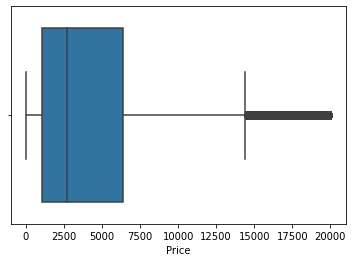

In [9]:
#target
sns.boxplot(x = data['Price'])
display(data.Price.mean())
plt.show()

<AxesSubplot:xlabel='Price', ylabel='Density'>

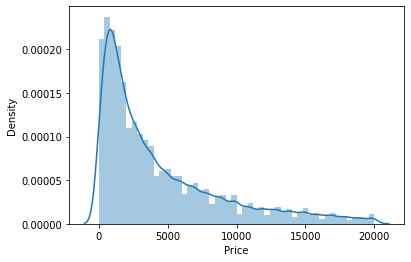

In [10]:
sns.distplot(data['Price'])

* Как уже было описано выше - будем удалять значения target признака, которые равны 0, так как цена не должна равняться 0.

In [11]:
display(data[data['Price'] <= 100]['Price'].count()/data.shape[0]*100)

4.048040319553911

* 4% подобных данных не так много, поэтому удаляем.

In [12]:
data = data.drop(data.query('Price<=100').index)
display(data.shape)

(340024, 15)

In [13]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [14]:
display(data.isna().sum())

DateCrawled              0
Price                    0
VehicleType          32251
RegistrationYear         0
Gearbox              16085
Power                    0
Model                16889
Kilometer                0
RegistrationMonth        0
FuelType             28004
Brand                    0
NotRepaired          63867
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

In [15]:
display(data[data['VehicleType'].isna() |
     data['Gearbox'].isna() |
     data['Model'].isna() |
     data['FuelType'].isna() |
     data['NotRepaired'].isna()]['Brand'].value_counts()
       )

volkswagen        22830
opel              12395
bmw                8722
mercedes_benz      7559
ford               7320
audi               7200
renault            5810
fiat               2996
peugeot            2960
sonstige_autos     2683
seat               1843
smart              1813
mazda              1513
citroen            1363
nissan             1321
skoda              1047
toyota              925
mitsubishi          896
hyundai             806
honda               800
volvo               655
suzuki              592
alfa_romeo          558
kia                 549
mini                477
chevrolet           423
chrysler            366
trabant             279
daihatsu            248
rover               199
subaru              198
daewoo              189
dacia               168
porsche             164
jeep                153
lancia              144
land_rover          117
jaguar              103
saab                102
lada                 69
Name: Brand, dtype: int64

In [16]:
display(data[data['VehicleType'].isna() &
     data['Gearbox'].isna() &
     data['Model'].isna() &
     data['FuelType'].isna() &
     data['NotRepaired'].isna()]['Brand'].value_counts()
       )

sonstige_autos    285
volkswagen        223
bmw               102
opel              101
mercedes_benz      77
audi               65
ford               49
renault            40
fiat               39
peugeot            30
mazda              27
trabant            25
seat               18
nissan             14
smart              13
citroen            13
alfa_romeo         12
honda              10
suzuki              8
hyundai             8
mitsubishi          7
chevrolet           7
toyota              5
chrysler            5
kia                 3
daewoo              3
skoda               3
daihatsu            2
volvo               2
mini                1
porsche             1
rover               1
Name: Brand, dtype: int64

**Пропуски найдены в следующих фичах:**

- VehicleType — тип кузова
- Gearbox — тип коробки передач
- Model — модель автомобиля
- FuelType — тип топлива
- NotRepaired — была машина в ремонте или нет

In [17]:
def visual_df_nulls(df):
    print('{:^52}{:^16}{:^20}'.format('Признак', 'Всего пропусков', 'Пропусков (%)'))
    for col in df.columns:
        missed_data_share = df[col].isnull().mean()*100
        missed_data_count = df[col].isnull().sum()
        print('{:<50}{:^16}{:>18.5f}'.format(col, missed_data_count, missed_data_share))

In [18]:
visual_df_nulls(data)

                      Признак                       Всего пропусков    Пропусков (%)    
DateCrawled                                              0                   0.00000
Price                                                    0                   0.00000
VehicleType                                            32251                 9.48492
RegistrationYear                                         0                   0.00000
Gearbox                                                16085                 4.73055
Power                                                    0                   0.00000
Model                                                  16889                 4.96700
Kilometer                                                0                   0.00000
RegistrationMonth                                        0                   0.00000
FuelType                                               28004                 8.23589
Brand                                                    0   

In [19]:
display(data['NotRepaired'].value_counts())

no     243064
yes     33093
Name: NotRepaired, dtype: int64

In [20]:
data = data.fillna('unknown')
display(data.isna().sum())
display(data.head())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [25]:
display(data['PostalCode'].value_counts())
display(data['PostalCode'].describe())

10115    811
65428    601
66333    320
44145    301
32257    297
        ... 
29496      1
86747      1
25889      1
6469       1
83546      1
Name: PostalCode, Length: 8137, dtype: int64

count    340024.000000
mean      50703.115257
std       25721.449527
min        1067.000000
25%       30455.000000
50%       49536.000000
75%       71229.000000
max       99998.000000
Name: PostalCode, dtype: float64

In [26]:
display(data.shape)
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis = 1)
display(data.shape)

(340024, 15)

(340024, 11)

### Работа с выбросами

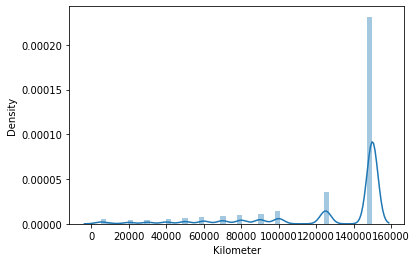

In [27]:
sns.distplot(data.Kilometer)
plt.show()

* Максимальный пробег около 150000 км. Данные вполне реальны, оставим без изменений.

In [28]:
display(part_of_value(df1=data.query('RegistrationMonth==0'), df=data))
display(data.query('RegistrationMonth==0').shape[0])

9.170235042232314

31181

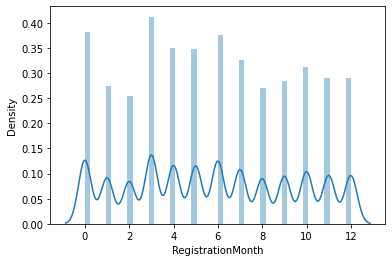

In [29]:
sns.distplot(data.RegistrationMonth)
plt.show()

* Нам необходимо обработать месяца = 0. Распределим значения по месяцам 1-12 так, чтобы не изменилось соотношение.

In [30]:
frac_list = []
for i in range(1,13):
    frac = data.query('RegistrationMonth==@i').shape[0]/(data.shape[0]-data.query('RegistrationMonth==0').shape[0])
    n_size = round(data.query('RegistrationMonth==0').shape[0]*frac)
    frac_list.append(n_size)

In [31]:
all_idx = np.array(data.query('RegistrationMonth==0').index)
for month, i in enumerate(frac_list):
    idx = np.random.choice(all_idx, size = i, replace = False)
    data.loc[idx, 'RegistrationMonth'] = (month+1)
    all_idx = all_idx[~np.isin(all_idx, idx)]

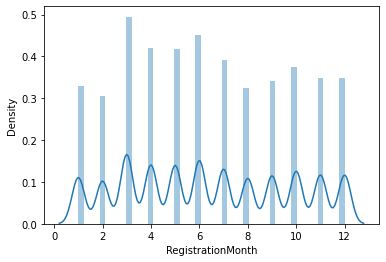

In [32]:
sns.distplot(data.RegistrationMonth)
plt.show()

In [33]:
display(part_of_value(df1 = data.query('RegistrationMonth==0'), df = data))

0.0

* На данном этапе мы перераспределили значения параметра RegistrationMonth, которые равнялись нулю.

In [34]:
print(f'Количество дубликатов в таблице = {data.duplicated().sum()}')

Количество дубликатов в таблице = 24782


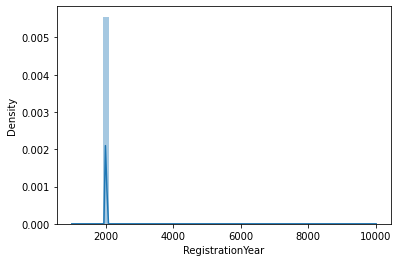

159

In [35]:
sns.distplot(data.RegistrationYear)
plt.show()
display(data.query('RegistrationYear <= 1930 | RegistrationYear >= 2021')['RegistrationYear'].count())

In [36]:
display(data.query('RegistrationYear <= 1930 | RegistrationYear >= 2016').head(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
15,450,small,1910,unknown,0,ka,5000,1,petrol,ford,unknown
16,300,unknown,2016,unknown,60,polo,150000,11,petrol,volkswagen,unknown
22,2900,unknown,2018,manual,90,meriva,150000,5,petrol,opel,no
26,5555,unknown,2017,manual,125,c4,125000,4,unknown,citroen,no
31,899,unknown,2016,manual,60,clio,150000,6,petrol,renault,unknown
35,350,unknown,2016,manual,75,golf,150000,4,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no
48,7750,unknown,2017,manual,80,golf,100000,1,petrol,volkswagen,unknown
51,2000,unknown,2017,manual,90,punto,150000,11,gasoline,fiat,yes
52,1400,unknown,2016,manual,55,other,5000,1,unknown,hyundai,unknown


* Удалим данные по автомобилям, которые зарегистрированы очень давно или далеко в будущем 

In [37]:
display(data.shape)
data.drop(data.query('RegistrationYear <= 1930 | RegistrationYear >= 2016').index, inplace=True)
display(data.shape)

(340024, 11)

(317499, 11)

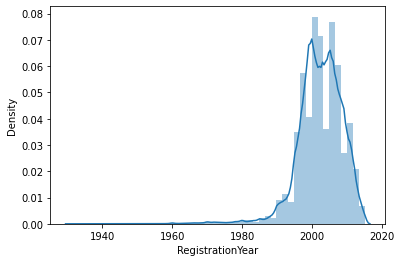

0

In [38]:
sns.distplot(data.RegistrationYear)
plt.show()
display(data.query('RegistrationYear <= 1930 | RegistrationYear >= 2016')['RegistrationYear'].count())

count    317499.000000
mean        113.438628
std         182.395893
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

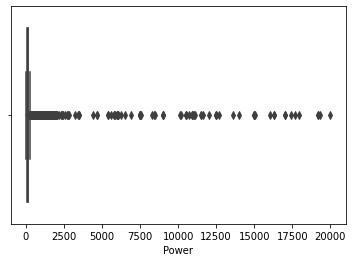

In [39]:
sns.boxplot(x = data['Power'])
display(data.Power.describe())
plt.show()

In [40]:
display(data.query('Power>=679 | Power<50').count())
display(data.query('Power>=679 | Power<50').head())

Price                34084
VehicleType          34084
RegistrationYear     34084
Gearbox              34084
Power                34084
Model                34084
Kilometer            34084
RegistrationMonth    34084
FuelType             34084
Brand                34084
NotRepaired          34084
dtype: int64

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,8,petrol,volkswagen,unknown
32,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no
54,4700,wagon,2005,manual,0,signum,150000,12,unknown,opel,no
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes
69,1200,coupe,2001,unknown,0,astra,150000,4,unknown,opel,unknown


* Данные по мощности выглядят неправдоподобными. Предлагаю заменить крайне мощные автомобили (+3 сигмы) и совсем немощные (<50 л.с., на основании бизнес-оценки) на медиану по брэнду и модели.

In [41]:
display(data.groupby(['Brand', 'Model'])['Power'].agg({'mean', 'median', 'count'}))

count  median        mean
Brand      Model                              
alfa_romeo 145          38   103.0   97.473684
           147         504   120.0  144.472222
           156         565   150.0  140.120354
           159         201   170.0  167.477612
           other       491   150.0  169.558045
...                    ...     ...         ...
volvo      v40         691   116.0  112.830680
           v50         241   136.0  137.236515
           v60          41   163.0  161.829268
           v70         607   163.0  158.163097
           xc_reihe    260   185.0  182.930769

[337 rows x 3 columns]

In [42]:
display(data.Power.describe())
data.loc[(data['Power']>=679) | (data['Power']<50), 'Power'] = np.nan
display(data.Power.describe())
data['Power'] = data['Power'].fillna(data.groupby(['Brand', 'Model'])['Power'].transform('median'))
data.dropna(inplace=True)
data['Power'] = data['Power'].astype('int')

count    317499.000000
mean        113.438628
std         182.395893
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

count    283415.000000
mean        122.684304
std          53.468503
min          50.000000
25%          80.000000
50%         115.000000
75%         150.000000
max         678.000000
Name: Power, dtype: float64

count    317498.000000
mean        120.720868
std          52.516896
min          50.000000
25%          79.000000
50%         110.000000
75%         150.000000
max         678.000000
Name: Power, dtype: float64

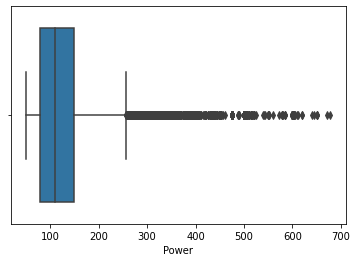

In [43]:
sns.boxplot(x = data['Power'])
display(data.Power.describe())
plt.show()

In [44]:
print('Описание количественных переменных')
print(data.describe())
print(f'Количество дубликатов в таблице = {data.duplicated().sum()}')

Описание количественных переменных
               Price  RegistrationYear          Power      Kilometer  \
count  317498.000000     317498.000000  317498.000000  317498.000000   
mean     4720.260313       2002.282455     120.720868  128209.059585   
std      4562.137283          6.487352      52.516896   37232.237500   
min       101.000000       1931.000000      50.000000    5000.000000   
25%      1290.000000       1999.000000      79.000000  125000.000000   
50%      2999.000000       2003.000000     110.000000  150000.000000   
75%      6800.000000       2007.000000     150.000000  150000.000000   
max     20000.000000       2015.000000     678.000000  150000.000000   

       RegistrationMonth  
count      317498.000000  
mean            6.389826  
std             3.351357  
min             1.000000  
25%             4.000000  
50%             6.000000  
75%             9.000000  
max            12.000000  
Количество дубликатов в таблице = 24496


**Промежуточные итоги:**

- удалили 3% данных
- аномалии по мощности заменили на медиану по брэнду и модели
- в конце получилось слишком много дубликатов, но это просто совпадение данных, поэтому ничего с этим делать не будем, оставим и будем двигаться дальше.

## Обучение моделей

In [45]:
# преобразуем категориальные данные методом прямого кодирования
data_ohe = data.copy
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,101,150000,8,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# разделим на выборки
X = data_ohe.drop(['Price'], axis = 1)
y = data_ohe['Price']
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(X, y, test_size=0.25, random_state=12345)

In [47]:
# произведем масштабирование признаков
scaler = StandardScaler()
scaler.fit(features_train_lr)

features_train_lr = scaler.transform(features_train_lr)
features_test_lr = scaler.transform(features_test_lr)

In [48]:
# преобразуем категориальные данные методом порядкового кодирования
le = LabelEncoder()
le_columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Model', 'Brand']
for x in le_columns:
    data[x] = le.fit_transform(data[x])
display(data.head(), data.shape)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,7,1993,1,101,116,150000,8,6,38,1
1,18300,2,2011,1,190,227,125000,5,2,1,2
2,9800,6,2004,0,163,117,125000,8,2,14,1
3,1500,5,2001,1,75,116,150000,6,6,38,0
4,3600,5,2008,1,69,101,90000,7,2,31,0


(317498, 11)

In [49]:
# разделим на выборки
X = data.drop(['Price'], axis = 1)
y = data['Price']
features_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.25, random_state=12345)
display(features_train.shape, features_test.shape)

(238123, 10)

(79375, 10)

* Выделили features и target. Разбили датасет на train и test

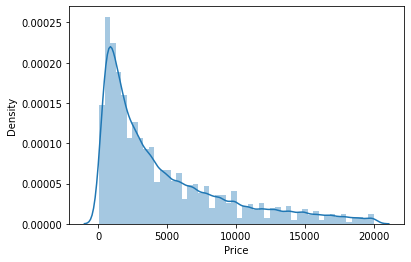

count    317498.000000
mean       4720.260313
std        4562.137283
min         101.000000
25%        1290.000000
50%        2999.000000
75%        6800.000000
max       20000.000000
Name: Price, dtype: float64

In [50]:
sns.distplot(y)
plt.show()
display(y.describe())

In [51]:
def learn_time(model, x_train, y_train):
    start = time.time()
    model.fit(x_train, y_train)
    end = time.time()
    time_fit = end - start
    return time_fit, model

In [52]:
def predict_time(model, x_test):
    start = time.time()
    predict = model.predict(x_test)
    end = time.time()
    time_predict = end - start
    return time_predict, predict

In [53]:
data_result = pd.DataFrame(columns = ['RMSE', 'Fit time', 'Predict time'])
display(data_result)

,RMSE,Fit time,Predict time


In [54]:
def data_metrics(RMSE, l_time, p_time, model_name, df):
    df.loc[model_name, 'RMSE'] = round(RMSE, 4)
    df.loc[model_name, 'Fit time'] = round(l_time, 4)
    df.loc[model_name, 'Predict time'] = round(p_time, 4)
    return df

* Здесь мы выполним настройку моделей.

### Линейная регрессия

In [55]:
LR_learn_time, LR_model = learn_time(LinearRegression(), features_train_lr, target_train_lr)
LR_pred_time, LR_predict = predict_time(LR_model, features_test_lr)
LR_RMSE = np.sqrt(mean_squared_error(target_test_lr, LR_predict))
display(data_metrics(LR_RMSE, LR_learn_time, LR_pred_time, 'LinearRegression', data_result))

,RMSE,Fit time,Predict time
LinearRegression,2587.0286,98.3753,0.09


* Качество линейной регресии оставляет желать лучшего.

### DecisionTree

In [56]:
mse = make_scorer(mean_squared_error,greater_is_better=False)

def model_train(model, params, features, target):
    start = time.time()
    grid=(GridSearchCV(model,
                     param_grid=params,
                     scoring=mse,
                     cv=5)
         ).fit(features, target)
    end = time.time()
    print('Время CV', round(end-start, 4))
    return grid.best_params_

In [57]:
"""DT_params = {
            'max_depth' : range(2, 21, 3),
            'min_samples_leaf' : range (1,16,2),
            #'min_samples_split' : [2,4],
            'random_state' : [12345]
        }

display(model_train(DecisionTreeRegressor(), DT_params, features_train, target_train))"""

"DT_params = {\n            'max_depth' : range(2, 21, 3),\n            'min_samples_leaf' : range (1,16,2),\n            #'min_samples_split' : [2,4],\n            'random_state' : [12345]\n        }\n\ndisplay(model_train(DecisionTreeRegressor(), DT_params, features_train, target_train))"

In [58]:
tree_l_time, tree_model = learn_time(DecisionTreeRegressor(max_depth=20,
                                                           min_samples_leaf=15,
                                                           random_state=12345), features_train, target_train)
tree_pred_time, tree_predict = predict_time(tree_model, features_test)
tree_RMSE = np.sqrt(mean_squared_error(target_test, tree_predict))
display(data_metrics(tree_RMSE, tree_l_time, tree_pred_time, 'DecisionTree', data_result))

,RMSE,Fit time,Predict time
LinearRegression,2587.0286,98.3753,0.09
DecisionTree,1780.9681,0.9566,0.0207


### Random Forest

In [59]:
"""RF_params = {
            'n_estimators' : range(10, 51, 10),
            'max_depth' : range(3, 16, 4),
            'random_state' : [12345]
        }

display(model_train(RandomForestRegressor(), RF_params, features_train, target_train))"""

"RF_params = {\n            'n_estimators' : range(10, 51, 10),\n            'max_depth' : range(3, 16, 4),\n            'random_state' : [12345]\n        }\n\ndisplay(model_train(RandomForestRegressor(), RF_params, features_train, target_train))"

In [60]:
RF_l_time, RF_model = learn_time(RandomForestRegressor(n_estimators=50,
                                                       max_depth=15,
                                                       random_state=12345), features_train, target_train)
RF_pred_time, RF_predict = predict_time(RF_model, features_test)
RF_RMSE = np.sqrt(mean_squared_error(target_test, RF_predict))
display(data_metrics(RF_RMSE, RF_l_time, RF_pred_time, 'RandomForest', data_result))

,RMSE,Fit time,Predict time
LinearRegression,2587.0286,98.3753,0.09
DecisionTree,1780.9681,0.9566,0.0207
RandomForest,1625.5173,28.7472,0.8372


### Light GBM

In [61]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

In [62]:
"""LGB_params = {
            'n_estimators' : range(80, 121, 10),
            'max_depth' : range(3, 16, 3),
            'objective' : ['regression'],
            'metric' : ['rmse'],
            'random_state' : [12345]
        }

display(model_train(LGBMRegressor(), LGB_params, features_train, target_train))"""

"LGB_params = {\n            'n_estimators' : range(80, 121, 10),\n            'max_depth' : range(3, 16, 3),\n            'objective' : ['regression'],\n            'metric' : ['rmse'],\n            'random_state' : [12345]\n        }\n\ndisplay(model_train(LGBMRegressor(), LGB_params, features_train, target_train))"

In [63]:
model_LGBMR = LGBMRegressor(max_depth=14, 
                            n_estimators=120, 
                            random_state=12345, 
                            objective='regression',
                            #num_leaves=1400,
                            metric='rmse')
start_l = time.time()
model_LGBMR.fit(features_train, target_train, categorical_feature=cat_features, verbose=10)
end_l = time.time()
LGBR_pred_time, LGBR_predict = predict_time(model_LGBMR, features_test)
LGBR_RMSE = np.sqrt(mean_squared_error(target_test, LGBR_predict))
display(data_metrics(LGBR_RMSE, round(end_l-start_l,4), LGBR_pred_time, 'LGBMR', data_result))

,RMSE,Fit time,Predict time
LinearRegression,2587.0286,98.3753,0.09
DecisionTree,1780.9681,0.9566,0.0207
RandomForest,1625.5173,28.7472,0.8372
LGBMR,1595.8535,86.3494,1.0846


In [64]:
"""model_LGBMR = LGBMRegressor(max_depth=14, 
                            n_estimators=120, 
                            random_state=12345, 
                            objective='regression',
                            #num_leaves=1400,
                            metric='rmse')
start_l = time.time()
model_LGBMR.fit(features_train, target_train, categorical_feature=cat_features, verbose=10)
end_l = time.time()
LGBR_pred_time, LGBR_predict = predict_time(model_LGBMR, features_test)
LGBR_RMSE = np.sqrt(mean_squared_error(target_test, LGBR_predict))
display(data_metrics(LGBR_RMSE, round(end_l-start_l,4), LGBR_pred_time, 'LGBMR', data_result))"""

"model_LGBMR = LGBMRegressor(max_depth=14, \n                            n_estimators=120, \n                            random_state=12345, \n                            objective='regression',\n                            #num_leaves=1400,\n                            metric='rmse')\nstart_l = time.time()\nmodel_LGBMR.fit(features_train, target_train, categorical_feature=cat_features, verbose=10)\nend_l = time.time()\nLGBR_pred_time, LGBR_predict = predict_time(model_LGBMR, features_test)\nLGBR_RMSE = np.sqrt(mean_squared_error(target_test, LGBR_predict))\ndisplay(data_metrics(LGBR_RMSE, round(end_l-start_l,4), LGBR_pred_time, 'LGBMR', data_result))"

### CatBoost

In [65]:
"""CBR_params = {
            'n_estimators' : range(80, 121, 20),
            'max_depth' : range(4, 11, 2),
            'cat_features' : [cat_features],
            'random_state' : [12345]
        }

display(model_train(CatBoostRegressor(), CBR_params, features_train, target_train))"""

"CBR_params = {\n            'n_estimators' : range(80, 121, 20),\n            'max_depth' : range(4, 11, 2),\n            'cat_features' : [cat_features],\n            'random_state' : [12345]\n        }\n\ndisplay(model_train(CatBoostRegressor(), CBR_params, features_train, target_train))"

In [66]:
"""model_CBR = CatBoostRegressor(max_depth=10, 
                            n_estimators=101, 
                            random_state=12345,
                            cat_features=cat_features)
start_l = time.time()
model_CBR.fit(features_train, target_train)
end_l = time.time()
CBR_pred_time, CBR_predict = predict_time(model_CBR, features_test)
CBR_RMSE = np.sqrt(mean_squared_error(target_test, CBR_predict))
display(data_metrics(CBR_RMSE, round(end_l-start_l,4), CBR_pred_time, 'CBR', data_result))"""

"model_CBR = CatBoostRegressor(max_depth=10, \n                            n_estimators=101, \n                            random_state=12345,\n                            cat_features=cat_features)\nstart_l = time.time()\nmodel_CBR.fit(features_train, target_train)\nend_l = time.time()\nCBR_pred_time, CBR_predict = predict_time(model_CBR, features_test)\nCBR_RMSE = np.sqrt(mean_squared_error(target_test, CBR_predict))\ndisplay(data_metrics(CBR_RMSE, round(end_l-start_l,4), CBR_pred_time, 'CBR', data_result))"

In [67]:
CAT_l_time, CAT_model = learn_time(CatBoostRegressor(n_estimators=100,
                                                     max_depth=10,
                                                     cat_features=cat_features,
                                                     random_state= 12345), features_train, target_train)
CAT_pred_time, CAT_predict = predict_time(CAT_model, features_test)
CAT_RMSE = np.sqrt(mean_squared_error(target_test, CAT_predict))
display(data_metrics(CAT_RMSE, CAT_l_time, CAT_pred_time, 'CatBoost', data_result))

Learning rate set to 0.5
0:	learn: 3054.4646076	total: 242ms	remaining: 23.9s
1:	learn: 2422.8823561	total: 421ms	remaining: 20.6s
2:	learn: 2121.9740377	total: 582ms	remaining: 18.8s
3:	learn: 1972.0655328	total: 743ms	remaining: 17.8s
4:	learn: 1895.0579859	total: 910ms	remaining: 17.3s
5:	learn: 1855.7104533	total: 1.07s	remaining: 16.8s
6:	learn: 1823.6178425	total: 1.23s	remaining: 16.3s
7:	learn: 1803.0381292	total: 1.41s	remaining: 16.2s
8:	learn: 1784.7676609	total: 1.6s	remaining: 16.1s
9:	learn: 1773.4798067	total: 1.75s	remaining: 15.8s
10:	learn: 1750.9261896	total: 1.9s	remaining: 15.4s
11:	learn: 1738.0823178	total: 2.06s	remaining: 15.1s
12:	learn: 1730.7171544	total: 2.22s	remaining: 14.9s
13:	learn: 1722.7342025	total: 2.39s	remaining: 14.7s
14:	learn: 1708.4455190	total: 2.54s	remaining: 14.4s
15:	learn: 1695.0363935	total: 2.7s	remaining: 14.2s
16:	learn: 1684.7051704	total: 2.85s	remaining: 13.9s
17:	learn: 1678.9424233	total: 3.01s	remaining: 13.7s
18:	learn: 1671.

,RMSE,Fit time,Predict time
LinearRegression,2587.0286,98.3753,0.09
DecisionTree,1780.9681,0.9566,0.0207
RandomForest,1625.5173,28.7472,0.8372
LGBMR,1595.8535,86.3494,1.0846
CatBoost,1596.2783,17.1924,0.1369


## Анализ моделей

In [68]:
y_hat = y.copy()
y_hat.loc[:] = y.mean()
const_RMSE = np.sqrt(mean_squared_error(y, y_hat))

In [69]:
display(data_metrics(const_RMSE, 0, 0, 'Const', data_result))

,RMSE,Fit time,Predict time
LinearRegression,2587.0286,98.3753,0.09
DecisionTree,1780.9681,0.9566,0.0207
RandomForest,1625.5173,28.7472,0.8372
LGBMR,1595.8535,86.3494,1.0846
CatBoost,1596.2783,17.1924,0.1369
Const,4562.1301,0,0


* Наши модели предсказывают лучше константной, что радует. Самая лучшая модель по параметрам RMSE, время обучения и время предсказания - LightGBM.

## Общий вывод

По итогу проекта:
* Былb загружены и обработаны данные.
* Были обучены разные модели, для каждой из которых были подобраны различные гиперпараметры.
* Был произведен анализ итоговых параметров моделей, где LightGBM показала наилучшие результаты, удовлетворяющие уcловиям проекта.